<a href="https://colab.research.google.com/github/yasyamauchi/education/blob/main/m5stack_imu2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# プロジェクトⅤ用(2025) m5stackのIMUデータ処理

2025/03/31　山内  
  
  2023年のものを以下のように改造  
  * サンプリング周波数は40Hzに上げる
  * X(前後方向)とY(左右方向)の回転角を扱う
  * スペクトログラムとフーリエ変換を行う

### Scipyの参考：  https://atatat.hatenablog.com/entry/data_proc_python4

# 1) m5StackのmicroSD内のファイル"A.csv", "B.csv", "C.csv"をGoogle Colabにアップロードする  
方法は別途指示する．

# 2)ファイル名を指定する

In [ ]:
filename = 'A.csv' #@param ["A.csv", "B.csv", "C.csv"] {allow-input: true}

# 3) メニューの「ランタイム」→「すべてのセルを実行」を選ぶ

In [ ]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

## ローパスフィルタの関数

In [ ]:
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y

## データファイルの読み込み

In [ ]:
m5stack = np.loadtxt(filename,delimiter=',',skiprows=1)

# 4) 結果を観察する

## 結果１：生データを観察する  
上からRotX(前後の傾き)，RotY(左右の傾き)，AccZ(上下の加速度)  
赤線はローパスフィルター処理後

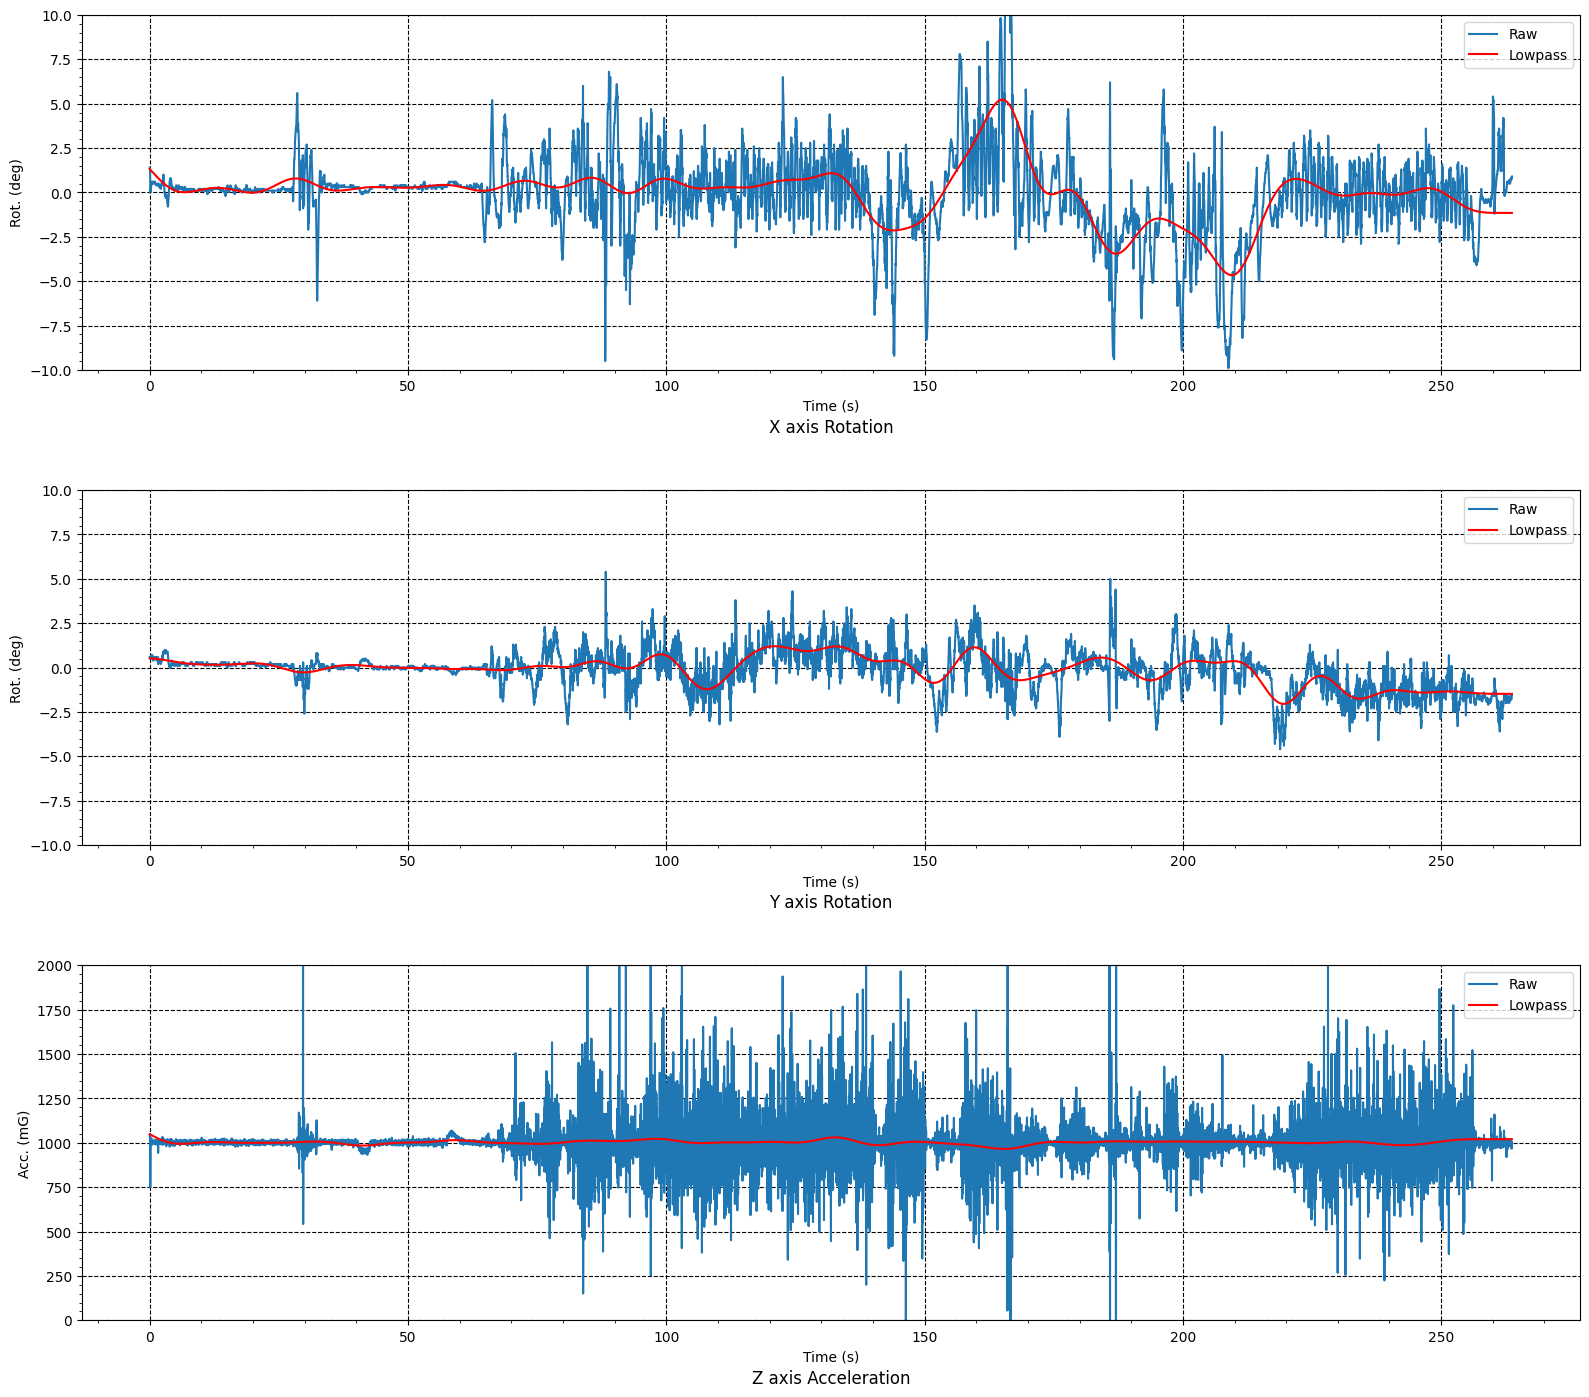

In [ ]:
samplerate = 40 # サンプリング周波数は10Hz
fp = 0.08 # 通過域端周波数[Hz]
fs = 0.2 # 阻止域端周波数[Hz]
gpass = 3 # 通過域端最大損失[dB]
gstop = 40 # 阻止域端最小損失[dB]

x = np.arange(0, m5stack.shape[0]) / samplerate
AccX = m5stack[:,4]
AccY = m5stack[:,5]
AccZ = m5stack[:,6]
RotX = m5stack[:,7]
RotY = m5stack[:,8]

# ローパスをする関数を実行
RotX_lofilt = lowpass(RotX, samplerate, fp, fs, gpass, gstop)
RotY_lofilt = lowpass(RotY, samplerate, fp, fs, gpass, gstop)
AccZ_lofilt = lowpass(AccZ, samplerate, fp, fs, gpass, gstop)

# グラフ描画
fig = plt.figure(figsize=(16,14))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.plot(x,RotX)
ax1.plot(x,RotX_lofilt,'r')
ax1.legend(['Raw','Lowpass'])
ax1.set_title('X axis Rotation', y=-0.2)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Rot. (deg)')
ax1.set_ylim(-10,10)
ax1.minorticks_on()
ax1.grid(color="black", linestyle="--")

ax2.plot(x,RotY)
ax2.plot(x,RotY_lofilt,'r')
ax2.legend(['Raw','Lowpass'])
ax2.set_title('Y axis Rotation', y=-0.2)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Rot. (deg)')
ax2.set_ylim(-10,10)
ax2.minorticks_on()
ax2.grid(color="black", linestyle="--")

ax3.plot(x,AccZ)
ax3.plot(x,AccZ_lofilt,'r')
ax3.legend(['Raw','Lowpass'])
ax3.set_title('Z axis Acceleration', y=-0.2)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Acc. (mG)')
ax3.set_ylim(0,2000)
ax3.minorticks_on()
ax3.grid(color="black", linestyle="--")

fig.tight_layout(h_pad=4)              #レイアウトの設定
plt.show()

## 結果２：フーリエ変換を実行する  
上からRotX(前後の傾き)，RotY(左右の傾き)

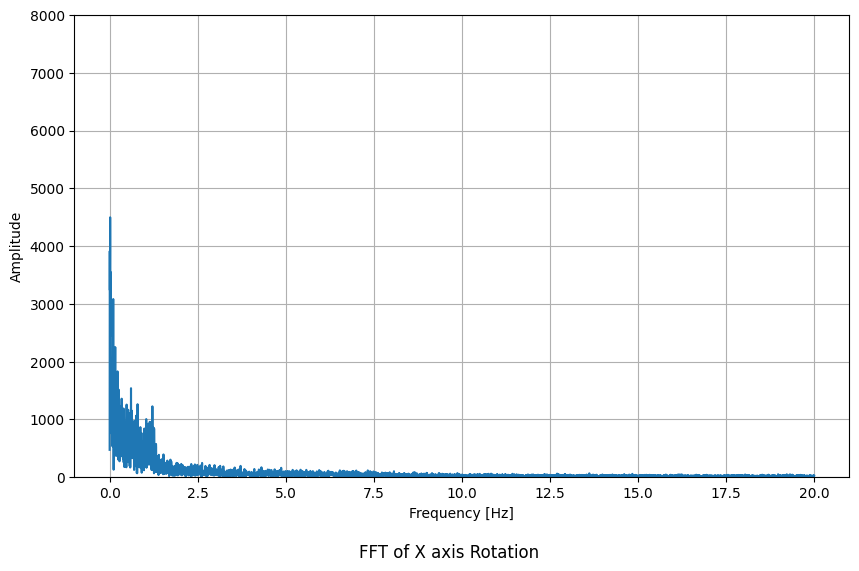

In [ ]:
from scipy.fft import fft, fftfreq

N = len(RotX) # Length of the AccY data
yf1 = fft(RotX) # Perform the Fourier Transform on RotX
xf1 = fftfreq(N, 1 / samplerate) # Generate frequency axis for the transformed data

# Plot the single-sided amplitude spectrum
fig = plt.figure(figsize=(10, 6))
plt.plot(xf1[0:N//2], np.abs(yf1[0:N//2])) # Plot the positive frequencies
fig.suptitle('FFT of X axis Rotation', y=0.0)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.ylim(0,8000)
plt.grid()

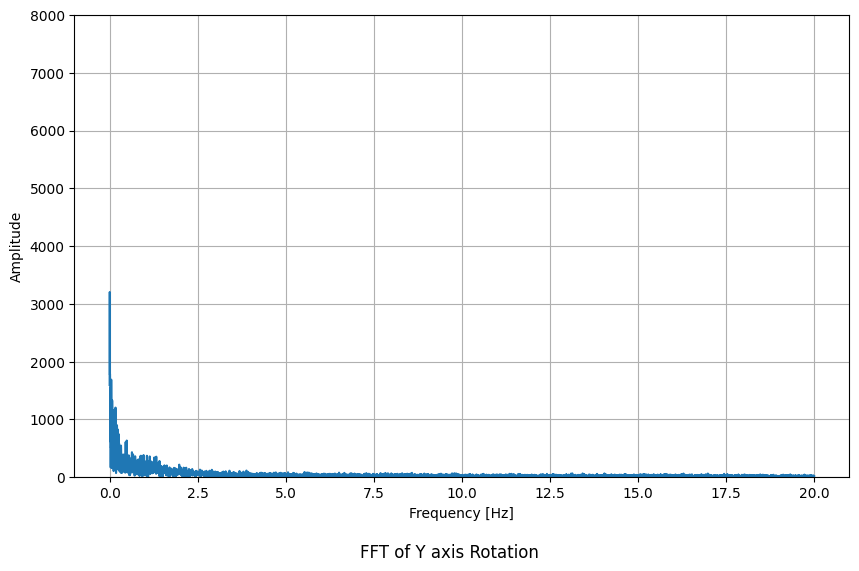

In [ ]:
from scipy.fft import fft, fftfreq

N = len(RotY) # Length of the AccY data
yf1 = fft(RotY) # Perform the Fourier Transform on RotX
xf1 = fftfreq(N, 1 / samplerate) # Generate frequency axis for the transformed data

# Plot the single-sided amplitude spectrum
fig = plt.figure(figsize=(10, 6))
plt.plot(xf1[0:N//2], np.abs(yf1[0:N//2])) # Plot the positive frequencies
fig.suptitle('FFT of Y axis Rotation', y=0.0)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.ylim(0,8000)
plt.grid()

## 結果３：スペクトログラムを観察する  
上からRotX(前後の傾き)，RotY(左右の傾き)  
条件：窓関数サイズ512，ホップサイズ128

Text(0.5, 0, 'Time [sec]')

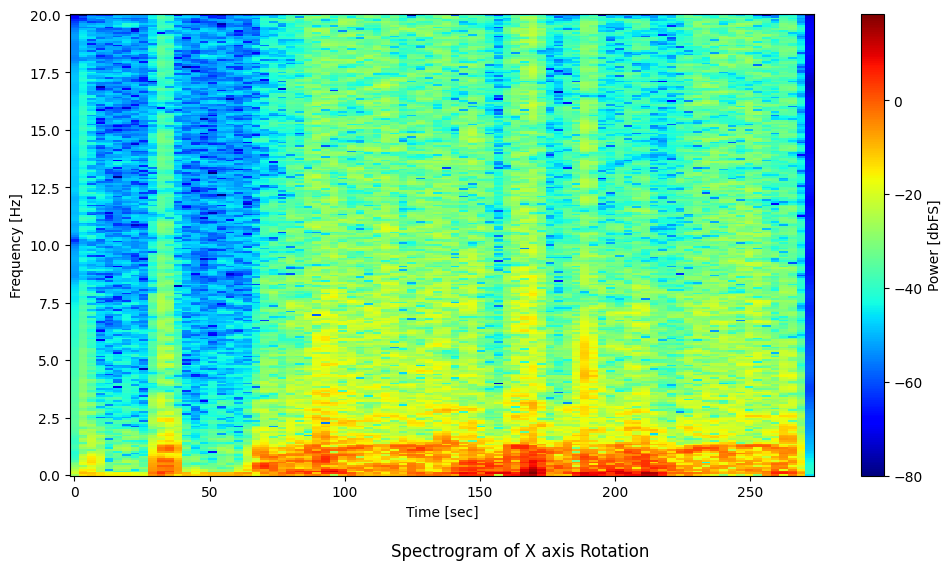

In [ ]:
# 参考：https://nettyukobo.com/python_scipy_signal_spectrogram/

# 窓関数作成
win = signal.windows.hann(512)  # 窓関数

# スぺクトログラム作成
SFT = signal.ShortTimeFFT(win, hop=128, fs=samplerate, fft_mode='onesided2X', scale_to='magnitude')
Sxx = SFT.spectrogram(RotX)
Sxx_dB = 10 * np.log10(np.fmax(Sxx, 1e-8))

# 時間軸と周波数軸の作成
N_t = np.arange(Sxx.shape[1])
t = SFT.delta_t * N_t
f = SFT.f

# グラフ作成
fig = plt.figure(figsize=(12,6))
fig.suptitle('Spectrogram of X axis Rotation', y=0.0)
plt.pcolormesh(t, f, Sxx_dB, cmap="jet")
plt.colorbar(label="Power [dbFS]")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

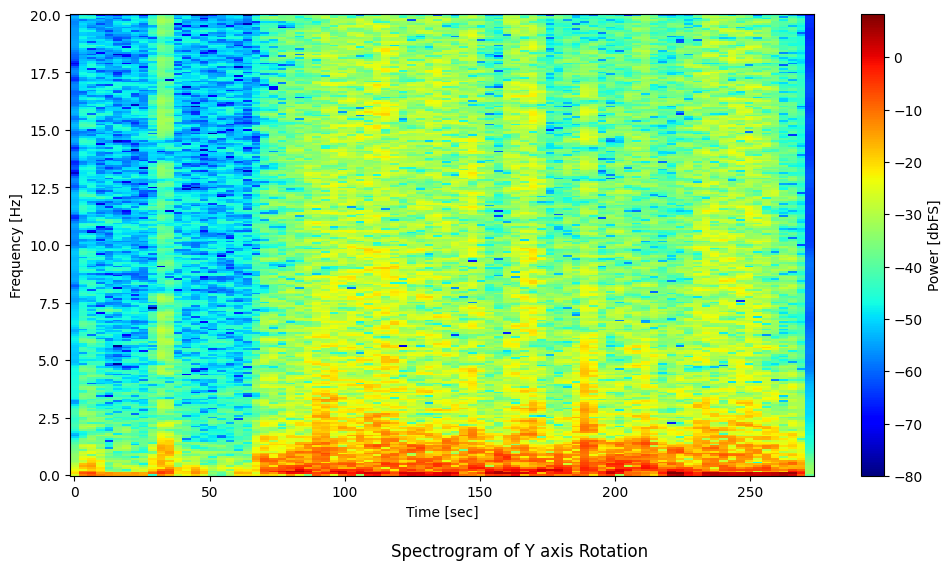

In [ ]:
# 参考：https://nettyukobo.com/python_scipy_signal_spectrogram/

# 窓関数作成
win = signal.windows.hann(512)  # 窓関数

# スぺクトログラム作成
SFT = signal.ShortTimeFFT(win, hop=128, fs=samplerate, fft_mode='onesided2X', scale_to='magnitude')
Sxx = SFT.spectrogram(RotY)
Sxx_dB = 10 * np.log10(np.fmax(Sxx, 1e-8))

# 時間軸と周波数軸の作成
N_t = np.arange(Sxx.shape[1])
t = SFT.delta_t * N_t
f = SFT.f

# グラフ作成
fig = plt.figure(figsize=(12,6))
fig.suptitle('Spectrogram of Y axis Rotation', y=0.0)
plt.pcolormesh(t, f, Sxx_dB, cmap="jet")
plt.colorbar(label="Power [dbFS]")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

# 4) 5つの図をすべて保存して持ち帰る  
Windowsの場合，グラフの上で右クリックして「名前をつけて画像を保存」  
区別がつくように気をつける！